In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# readfile
df = pd.read_csv("labelleddata.csv",encoding = "ISO-8859-1")

In [3]:
df.head()
# Display new class counts
df.Sentiment.value_counts()

Positive    3089
Negative    2371
Name: Sentiment, dtype: int64

In [38]:
df_pos = df[df.Sentiment == 'Positive']
df_neg = df[df.Sentiment == 'Negative']

df_pos_downsampled = resample(df_pos, 
                                 replace=False,    # sample without replacement
                                 n_samples=2371,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_senti = pd.concat([df_pos_downsampled, df_neg])
df_senti.head()
# Display new class counts
df_senti.Sentiment.value_counts()

Positive    2371
Negative    2371
Name: Sentiment, dtype: int64

In [6]:
X = df_senti['Text']
y = df_senti['Sentiment']
rationale = df_senti['Rationale']

<h1>Using Count Vectorizer</h1>

<h2> Learning without Rationale</h2>

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33, random_state = 0)
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

<h2>Multinomial Naive Bayes - LwoR </h2>

In [8]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,y_pred_test))

 Train Accuracy = 0.857770800628
 Test Accuracy 	= 0.790312300829


<h2>Logistic Regression - LwoR</h2>

In [9]:
LR_CLF = LogisticRegression(penalty='l2')
LR_CLF_fit = LR_CLF.fit(X_train,y_train)
y_pred_train = LR_CLF.predict(X_train)
LR_CLF_predict = LR_CLF.predict(X_test)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,LR_CLF_predict))

 Train Accuracy = 0.997174254317
 Test Accuracy 	= 0.933715742511


<h2>SVM -LwoR</h2>

In [10]:
linsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
linsvc.fit(X_train, y_train)
y_pred_train = linsvc.predict(X_train)
lin_predict = linsvc.predict(X_test)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,lin_predict))

 Train Accuracy = 1.0
 Test Accuracy 	= 0.932441045252


<h2>Learning with Rationale</h2>

In [11]:
chi2score = chi2(X_train, y_train)[0]
# len(chi2score)

In [12]:
def get_rationale_ChiSquare(tweet_rat_set):
    f_chi =[]
    f_chi_val=[]
    tweet_rat_list= list(tweet_rat_set)
    for r in tweet_rat_list:
        arg = features.index(r)
        f_chi.append(r)
        f_chi_val.append(chi2score[arg])
    rat = f_chi[np.argmax(f_chi_val)]
    return rat

In [13]:
X_train.shape

(3185, 6648)

In [14]:
# print(count_vect.get_feature_names())
features = count_vect.get_feature_names()
# len(features)

In [15]:
featurelist = []

r=1
# o =0.1
o=0.01
for tweetNum in range(0,X_train.shape[0]):
#     print("TweetNum = "+str(tweetNum))
    l1 = X_train[tweetNum].indices.tolist()
    l2 = X_train[tweetNum].data.tolist()

    weight = 0
    tweet_rationales={}
    tweetfeatures =[]
    for i in range(0,len(l1)):
        tweetfeatures.append(features[l1[i]])
    
    tweet_rationale=""
    if (set(rationale) & set(tweetfeatures)):
        tweet_rationales_set = set(rationale) & set(tweetfeatures)
        tweet_rationale = get_rationale_ChiSquare(tweet_rationales_set)

    #print(tweet_rationale)
    for i in range(0,len(l1)):
        if tweet_rationale == features[l1[i]] and tweet_rationale!="":
#             print("R "+tweet_rationale)
            weight = l2[i]*r
        else:
            weight = l2[i]*o

               
#         print(features[l1[i]]+ " "+str(weight))
        featurelist.append([tweetNum,l1[i],weight])
                
#         print(features[l1[i]]+ " "+str(l2[i]*o))
#         featurelist.append([tweetNum,l1[i],l2[i]*o])
                
# print(featurelist)
print(type(featurelist))
# len(featurelist)

<class 'list'>


In [16]:
# X_train_featurelist = get_Rationale_FeatureList(X_train)
rows,cols,vals = zip(*featurelist)
X_train_LWR = csr_matrix((vals,(rows,cols)))
#print(count_vect.get_feature_names())

print((X_train_LWR.shape))
print(X_test.shape)

(3185, 6648)
(1569, 6648)


<h2>Multinomial Naive Bayes - LwR </h2>

In [17]:
clf = MultinomialNB()
clf.fit(X_train_LWR, y_train)
y_pred_LWR = clf.predict(X_test)
y_pred_train_LWR = clf.predict(X_train_LWR)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train_LWR))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,y_pred_LWR))

 Train Accuracy = 0.932182103611
 Test Accuracy 	= 0.896749521989


<h2>Logistic Regression - LWR</h2>

In [18]:
LR_CLF = LogisticRegression(penalty='l2')
LR_CLF_fit = LR_CLF.fit(X_train_LWR,y_train)
LR_CLF_predict = LR_CLF.predict(X_test)
y_pred_train_LWR = LR_CLF.predict(X_train_LWR)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train_LWR))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,LR_CLF_predict))

 Train Accuracy = 0.932182103611
 Test Accuracy 	= 0.940089228808


<h2>Linear SVC -LWR </h2>

In [19]:
linsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
linsvc.fit(X_train_LWR, y_train)
lin_predict = linsvc.predict(X_test)
y_pred_train_LWR = linsvc.predict(X_train_LWR)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train_LWR))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,lin_predict))

 Train Accuracy = 0.932182103611
 Test Accuracy 	= 0.85022307202


<h1>Using Tfidf Vectorizer</h1>

<h2>Learning without Rationale</h2>

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33, random_state = 0)
tfidf_vect = TfidfVectorizer()
X_train = tfidf_vect.fit_transform(X_train)
X_test = tfidf_vect.transform(X_test)

<h2>Multinomial Naive Bayes</h2>

In [21]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,y_pred_test))

 Train Accuracy = 0.880062794349
 Test Accuracy 	= 0.806883365201


<h2>Logistic Regression</h2>

In [22]:
LR_CLF = LogisticRegression(penalty='l2')
LR_CLF_fit = LR_CLF.fit(X_train,y_train)
LR_CLF_predict = LR_CLF.predict(X_test)
y_pred_train = LR_CLF.predict(X_train)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train))
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,LR_CLF_predict))

 Train Accuracy = 0.958241758242
 Test Accuracy 	= 0.883365200765


<h2>LinearSVC</h2>

In [23]:
linsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
linsvc.fit(X_train, y_train)
lin_predict = linsvc.predict(X_test)
y_pred_train = linsvc.predict(X_train)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train))

print(" Test Accuracy \t=",metrics.accuracy_score(y_test,lin_predict))

 Train Accuracy = 0.999058084772
 Test Accuracy 	= 0.912683237731


<h2>Learning with Rationale</h2>

In [24]:
chi2score = chi2(X_train, y_train)[0]

In [25]:
def get_rationale_ChiSquare(tweet_rat_set):
    f_chi =[]
    f_chi_val=[]
    tweet_rat_list= list(tweet_rat_set)
    for r in tweet_rat_list:
        arg = features.index(r)
        f_chi.append(r)
        f_chi_val.append(chi2score[arg])
    rat = f_chi[np.argmax(f_chi_val)]
    return rat

In [26]:
features = tfidf_vect.get_feature_names()

In [27]:
featurelist = []

r=1
o=0.01
for tweetNum in range(0,X_train.shape[0]):
#     print("TweetNum = "+str(tweetNum))
    l1 = X_train[tweetNum].indices.tolist()
    l2 = X_train[tweetNum].data.tolist()

    weight = 0
    tweet_rationales={}
    tweetfeatures =[]
    for i in range(0,len(l1)):
        tweetfeatures.append(features[l1[i]])
    
    tweet_rationale=""
    if (set(rationale) & set(tweetfeatures)):
        tweet_rationales_set = set(rationale) & set(tweetfeatures)
        tweet_rationale = get_rationale_ChiSquare(tweet_rationales_set)

    #print(tweet_rationale)
    for i in range(0,len(l1)):
        if tweet_rationale == features[l1[i]] and tweet_rationale!="":
#             print("R "+tweet_rationale)
            weight = l2[i]*r
        else:
            weight = l2[i]*o

               
#         print(features[l1[i]]+ " "+str(weight))
        featurelist.append([tweetNum,l1[i],weight])
                
#         print(features[l1[i]]+ " "+str(l2[i]*o))
#         featurelist.append([tweetNum,l1[i],l2[i]*o])
                
# print(featurelist)
print(type(featurelist))
# len(featurelist)

<class 'list'>


In [28]:
rows,cols,vals = zip(*featurelist)
X_train_LWR = csr_matrix((vals,(rows,cols)))

<h2>MultinomialNB</h2>

In [29]:
clf = MultinomialNB()
clf.fit(X_train_LWR, y_train)
y_pred_train_LWR = clf.predict(X_train_LWR)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train_LWR))
y_pred_LWR = clf.predict(X_test)
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,y_pred_LWR))

 Train Accuracy = 0.934693877551
 Test Accuracy 	= 0.927979604844


<h2>Logistic Regression</h2>

In [30]:
LR_CLF = LogisticRegression(penalty='l2')
LR_CLF_fit = LR_CLF.fit(X_train_LWR,y_train)
y_pred_train_LWR = LR_CLF.predict(X_train_LWR)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train_LWR))

LR_CLF_predict = LR_CLF.predict(X_test)
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,LR_CLF_predict))

 Train Accuracy = 0.932182103611
 Test Accuracy 	= 0.934353091141


<h2>Linear SVC</h2>

In [31]:
linsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
linsvc.fit(X_train_LWR, y_train)
y_pred_train_LWR = linsvc.predict(X_train_LWR)
print(" Train Accuracy =",metrics.accuracy_score(y_train,y_pred_train_LWR))

lin_predict = linsvc.predict(X_test)
print(" Test Accuracy \t=",metrics.accuracy_score(y_test,lin_predict))

 Train Accuracy = 0.934693877551
 Test Accuracy 	= 0.934353091141


In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33, random_state = 0)
tfidf_vect = TfidfVectorizer()
X_train = tfidf_vect.fit_transform(X_train)
X_test = tfidf_vect.transform(X_test)
splitlist = [50,100,150,200]
clf = MultinomialNB()
LR_CLF = LogisticRegression(penalty='l2')
linsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
# print(y_test[:20])

In [33]:
acc_LwoR_NB =[]
acc_LwoR_LR =[]
acc_LwoR_SVM = []

for trainvalue in splitlist:
#     print(trainvalue)
    X_train_LwoR =X_train[:trainvalue]
    y_train_LwoR =y_train[:trainvalue]
#     print(y_train_LwoR)
    clf.fit(X_train_LwoR, y_train_LwoR)
    y_pred_LwoR = clf.predict(X_test)
    acc_LwoR_NB.append(metrics.accuracy_score(y_test,y_pred_LwoR))
#     print("Multinomial NB Test Accuracy "+str(trainvalue)+"docs for train\t=",metrics.accuracy_score(y_test,y_pred_LwoR))
    
    LR_CLF_fit = LR_CLF.fit(X_train_LwoR,y_train_LwoR)
    yLR_LwoR = LR_CLF.predict(X_test)
    acc_LwoR_LR.append(metrics.accuracy_score(y_test,yLR_LwoR))
#     print("Logistic Regression Test Accuracy "+str(trainvalue)+" docs for train\t=",metrics.accuracy_score(y_test,yLR_LwoR))
    
    linsvc.fit(X_train_LwoR, y_train_LwoR)
    ylin_LwoR = linsvc.predict(X_test)
    acc_LwoR_SVM.append(metrics.accuracy_score(y_test,ylin_LwoR))
#     print("Linear SVC Test Accuracy "+str(trainvalue)+" docs for train\t=",metrics.accuracy_score(y_test,ylin_LwoR))

In [34]:
acc_LwR_NB =[]
acc_LwR_LR =[]
acc_LwR_SVM = []
# print(X_test.shape)
# print(y_test.shape)
for trainvalue in splitlist:
#     print(trainvalue)
    X_train_LwR =X_train_LWR[:trainvalue]
    y_train_LwR =y_train[:trainvalue]
#     print(X_train_LwR.shape)
    clf.fit(X_train_LwR, y_train_LwR)
    y_pred_LwR = clf.predict(X_test)
    acc_LwR_NB.append(metrics.accuracy_score(y_test,y_pred_LwR))
#     print("Multinomial NB Test Accuracy "+str(trainvalue)+"docs for train\t=",metrics.accuracy_score(y_test,y_pred_LwR))
    
    LR_CLF_fit = LR_CLF.fit(X_train_LwR,y_train_LwR)
    yLR_LwR = LR_CLF.predict(X_test)
    acc_LwR_LR.append(metrics.accuracy_score(y_test,yLR_LwR))
#     print("Logistic Regression Test Accuracy "+str(trainvalue)+" docs for train\t=",metrics.accuracy_score(y_test,yLR_LwR))
    
    linsvc.fit(X_train_LwR, y_train_LwR)
    ylin_LwR = linsvc.predict(X_test)
    acc_LwR_SVM.append(metrics.accuracy_score(y_test,ylin_LwR))
#     print("Linear SVC Test Accuracy "+str(trainvalue)+" docs for train\t=",metrics.accuracy_score(y_test,ylin_LwR))

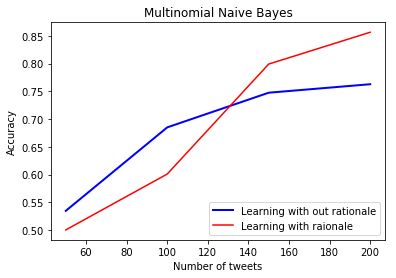

In [39]:
fig, ax = plt.subplots()
line1, = ax.plot(splitlist,acc_LwoR_NB,'b', linewidth=2,
                 label='Learning with out rationale')

line2, = ax.plot(splitlist, acc_LwR_NB,'r',label='Learning with raionale')
ax.set_title("Multinomial Naive Bayes")
ax.legend(loc='lower right')
plt.xlabel("Number of tweets")
plt.ylabel("Accuracy")
plt.show()

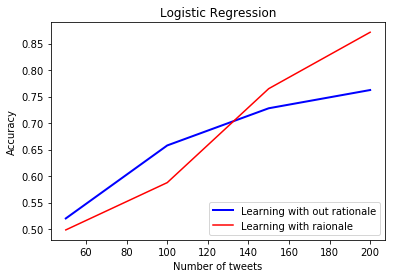

In [40]:
fig, ax = plt.subplots()
line1, = ax.plot(splitlist,acc_LwoR_LR,'b', linewidth=2,
                 label='Learning with out rationale')
line2, = ax.plot(splitlist, acc_LwR_LR,'r',label='Learning with raionale')
ax.set_title("Logistic Regression")
ax.legend(loc='lower right')
plt.xlabel("Number of tweets")
plt.ylabel("Accuracy")
plt.show()

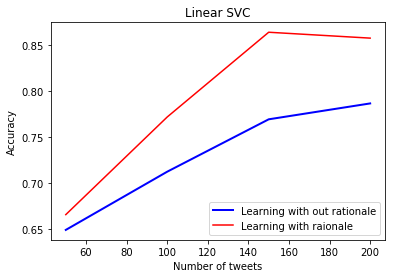

In [41]:
fig, ax = plt.subplots()
line1, = ax.plot(splitlist,acc_LwoR_SVM,'b', linewidth=2,
                 label='Learning with out rationale')
line2, = ax.plot(splitlist, acc_LwR_SVM,'r',label='Learning with raionale')
ax.set_title("Linear SVC")
ax.legend(loc='lower right')
plt.xlabel("Number of tweets")
plt.ylabel("Accuracy")
plt.show()